In [1]:
# @title Library Installation
# The installation is performed in a single block for optimization

print("Updating pip...")
!pip install --upgrade pip

# --- Uninstallation to ensure a clean installation of specific versions ---
print("Uninstalling PyTorch, Flash-Attention, and BitsAndBytes for a clean installation...")
!pip uninstall -y torch torchvision torchaudio flash-attn bitsandbytes transformers accelerate peft sentence-transformers

# --- Crucial Step: Install PyTorch 2.4.1 for CUDA 12.4 ---
# The torch index URL for CUDA 12.4 is https://download.pytorch.org/whl/cu124
# We force version 2.4.1 to match the configuration.
CUDA_VERSION_FOR_TORCH = "cu124"
TORCH_INDEX_URL = f"https://download.pytorch.org/whl/{CUDA_VERSION_FOR_TORCH}"

print(f"Installing torch==2.4.1 and CUDA dependencies for {CUDA_VERSION_FOR_TORCH}...")
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url {TORCH_INDEX_URL}

# --- Install Hugging Face Transformers and Accelerate ---
# These are key dependencies for many models and must be installed after PyTorch
# to ensure the correct versions are linked.
print("Installing Hugging Face Transformers and Accelerate...")
!pip install transformers accelerate

# --- Install Flash Attention 2.6.3 and BitsAndBytes ---
print("Installing flash-attn==2.6.3 and bitsandbytes...")
!pip install flash-attn==2.6.3 --no-build-isolation
!pip install bitsandbytes --upgrade

# --- Install other necessary libraries, including those that caused the error ---
# By installing these after their dependencies (transformers, accelerate),
# it ensures that `pip` finds the required packages.
print("Installing other necessary libraries...")
!pip install peft sentence-transformers
!pip install pandas numpy matplotlib seaborn scikit-learn google-generativeai pillow requests anthropic tensorflow qwen-vl-utils

print("\nInstallation complete. Check the messages to confirm there are no errors.")


Updating pip...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Uninstalling PyTorch, Flash-Attention, and BitsAndBytes for a clean installation...
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.56.1
Uninstalling transformers-4.56.1:
  Successfully uninstalled transformers-4.56.1
Found existing installation: accelerate 1.10.1
Uninstalling accelerate-1.10.1:
  Successfully uninstalled accelerate-1.10.1
Found existing ins

In [2]:
!nvidia-smi

Sun Sep 21 11:34:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   32C    P8             16W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# @title Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline

from PIL import Image

import requests
from io import BytesIO
import base64
import os
import torch
import anthropic

from qwen_vl_utils import process_vision_info

from huggingface_hub import login
from google.colab import userdata
import google.generativeai as genai

import re
from datetime import datetime
import sys
import xml.etree.ElementTree as ET
import time
import json
from functools import partial
import traceback

print("Imports completed.")

Imports completed.


In [4]:
import transformers
print(transformers.__version__)

4.56.2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [7]:
path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df = pd.read_csv(path, encoding='utf-8')

# Mostrar las primeras filas
print(df.head())

                                                 url  \
0  http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3...   
1  http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bj...   
2  http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgq...   
3              http://01anjali2001.github.io/netflix   
4  http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj...   

                                        html_content  \
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...   
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...   
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...   
3      0004_01anjali2001.github.io_netflix/page.html   
4  0005_bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a...   

                                          screenshot  label  
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...      1  
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...      1  
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...      1  
3  0004_01anjali2001.github.io_netflix/screenshot...      1  
4  0005_bafybeid

In [8]:
df.dropna(inplace=True)

print(df.info())

print(df.describe())

print(df.isnull().sum())

if 'label' in df.columns:
    print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           1000 non-null   object
 1   html_content  1000 non-null   object
 2   screenshot    1000 non-null   object
 3   label         1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
           label
count  1000.0000
mean      0.8000
std       0.4002
min       0.0000
25%       1.0000
50%       1.0000
75%       1.0000
max       1.0000
url             0
html_content    0
screenshot      0
label           0
dtype: int64
label
1    800
0    200
Name: count, dtype: int64


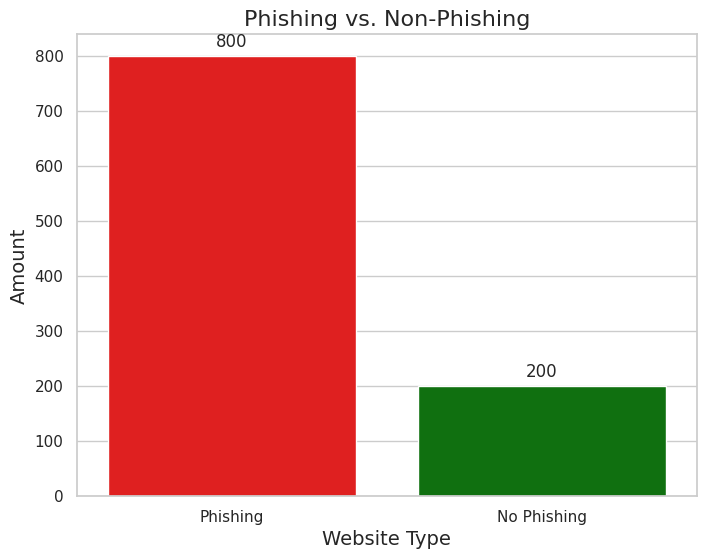

In [9]:
# Create a dictionary to map the labels
label_map = {0: 'No Phishing', 1: 'Phishing'}

# Create a new column with the mapped labels
df['label_name'] = df['label'].map(label_map)

# Set the seaborn style
sns.set(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label_name', data=df, hue='label_name', palette={'No Phishing': 'green', 'Phishing': 'red'}, legend=False)

# Add title and labels
plt.title('Phishing vs. Non-Phishing', fontsize=16)
plt.xlabel('Website Type', fontsize=14)
plt.ylabel('Amount', fontsize=14)

# Add value annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

# Display the chart
plt.show()

In [10]:
MODELOS_OPEN_SOURCE = {
    'Qwen/Qwen2-VL-2B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'Qwen/Qwen2.5-VL-3B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'Qwen/Qwen2-VL-7B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'Qwen/Qwen2.5-VL-7B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'llava-hf/llava-1.5-7b-hf': {
        'type': 'llava',
        'max_tokens': 8000,
    },
    'llava-hf/llama3-llava-next-8b-hf': {
        'type': 'llava',
        'max_tokens': 8000,
        'device': 0,
    },
    'context-labs/meta-llama-Llama-3.2-11B-Vision-Instruct-FP16': {
        'type': 'context-labs',
        'max_tokens': 8000,
    },
    'microsoft/Phi-3.5-vision-instruct': {
        'type': 'phi',
        'max_tokens': 8000,
    },
    'ByteDance-Seed/UI-TARS-1.5-7B': {
        'type': 'ByteDance',
        'max_tokens': 8000,
    },

}


In [11]:
def _configure_pipeline(model_id: str, models_config: dict):
    """
    Configures and loads the Hugging Face pipeline for a given model.

    Args:
        model_id (str): The identifier of the model to be loaded.
        models_config (dict): A dictionary containing model-specific configurations.

    Returns:
        tuple: A tuple containing the loaded pipeline, its configuration, and the pad token ID.

    Raises:
        ValueError: If the model configuration is not found.
    """
    print(f"⚡ Configuring and loading pipeline for {model_id}...")
    if model_id not in models_config:
        raise ValueError(f"Configuration not found for the model: {model_id}")
    config = models_config[model_id]

    # Clear cache before loading
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Determine the appropriate torch dtype
    torch_dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
    print(f"Using torch_dtype: {torch_dtype}")

    # Load the pipeline
    pipe = pipeline(
        "image-text-to-text",
        model=model_id,
        model_kwargs={"torch_dtype": torch_dtype},
        device_map="auto",
        trust_remote_code=True
    )

    # Try to get pad_token_id or eos_token_id
    pad_token_id = pipe.tokenizer.pad_token_id if pipe.tokenizer.pad_token_id is not None else pipe.tokenizer.eos_token_id
    if pad_token_id is None:
        print("⚠️ Warning: Could not get pad_token_id or eos_token_id.")

    print(f"✅ Pipeline '{model_id}' loaded successfully.")
    return pipe, config, pad_token_id


In [12]:
def _load_row_data(row: pd.Series, base_path: str):
    """
    Loads HTML content and a screenshot image from a single row of a DataFrame.

    Args:
        row (pd.Series): A row containing file paths for 'html_content' and 'screenshot'.
        base_path (str): The base directory where the files are stored.

    Returns:
        tuple: A tuple containing the HTML content (str) and the prepared screenshot (PIL.Image).

    Raises:
        ValueError: If the screenshot image cannot be loaded.
    """
    html_path = os.path.join(base_path, row['html_content'])
    screenshot_path = os.path.join(base_path, row['screenshot'])

    # Read HTML
    with open(html_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    # Load and prepare image
    screenshot = Image.open(screenshot_path).convert('RGB')
    if screenshot is None:
        raise ValueError(f"Could not load the image: {screenshot_path}")
    screenshot = screenshot.resize((512, 512)) # Resize

    return html_content, screenshot

In [13]:
def prompt_option1(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]
    return prompt

In [14]:
def prompt_option2(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Consider:
                      1.Identification of the main brand the page is attempting to represent
                      2.Suspicious elements (credential fields, urgent calls to action)
                      3.Consistency between the identified brand and the displayed domain
                      4.Typical visual characteristics of phishing (low-quality logos, typographical errors)
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]
    return prompt

In [15]:
def prompt_option3(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
              [Context] You are a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
              Follow this process:

                  Visual Analysis:
                      Identify the main visual elements (logos, colors, structure)
                      Look for inconsistencies in the design or low-quality elements
                      Detect any fields for entering sensitive data

                  Content Analysis:
                      Extract the main text and analyze its tone and content
                      Look for urgent language or threats
                      Verify consistency with the supposed brand

                  URL Analysis:
                      Examine the domain and compare it with the identified brand
                      Look for suspicious characters or typosquatting techniques

                  Conclusion:
                      Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name

              """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]
    return prompt

In [16]:
def _generate_response(pipe, messages: list, config: dict, pad_token_id: int):
    """
    Generates the model's response using the pipeline.
    """
    # Prepares kwargs for generation, ensuring pad_token_id is not None if necessary
    generate_kwargs = {
        "do_sample": False,
        # Only add pad_token_id if it's not None
        **({"pad_token_id": pad_token_id} if pad_token_id is not None else {})
    }

    outputs = pipe(
        text=messages, # 'text' is the expected argument for the image-text-to-text pipeline
        max_new_tokens=config.get('max_tokens', 512), # Use .get with a default value
        generate_kwargs=generate_kwargs
    )

    # Access the generated text. The exact structure may vary slightly.
    # Check the actual output of your pipeline if this fails.
    if outputs and isinstance(outputs, list) and 'generated_text' in outputs[0]:
        return outputs[0]['generated_text']
    else:
        print(f"⚠️ Unexpected pipeline output: {outputs}")
        return "Error: Unexpected output format"

In [17]:
def _process_row(row: pd.Series, pipe, config: dict, pad_token_id: int, base_path: str, output_filepath: str, prompt_method_to_use):
    """
    Processes a single row from the DataFrame: loads data, builds the prompt, and generates a response.
    """
    url = row.get('url', 'unknown URL')
    label = row.get('label', 'unknown Label')
    label_text = "PHISHING (true)" if label == 1 else "SAFE (false)"
    try:
        # 1. Load data
        html_content, screenshot = _load_row_data(row, base_path)

        # 2. Build prompt
        # Here we use the function that was passed as an argument!
        messages = prompt_method_to_use(html_content, screenshot, url)

        # 3. Generate Response
        generated_text = _generate_response(pipe, messages, config, pad_token_id)

        format_text = _process_generated_text(generated_text)

        # 4. Log output (as in your original code)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"--- FULL Output for URL: {url} {label_text} ({timestamp}) ---")
        print(format_text)
        print(f"--- End of Full Output ---")

        try:
            with open(output_filepath, 'a', encoding='utf-8') as f:
                f.write(f"URL: {url}\n")
                f.write(f"\nExpected Result: {label_text}\n")
                f.write(f"Output: {format_text}\n\n")
        except IOError as e:
            print(f"❌ Error writing to file {output_filepath} for {url}: {e}")

        # 5. Return the result for the 'prediction' column
        return format_text

    except FileNotFoundError as e:
        print(f"❌ Error - File not found for {url}: {e}")
        return f"Error: File not found ({e.filename})"
    except ValueError as e:
        print(f"❌ Error - Invalid value (e.g., image loading) for {url}: {e}")
        return f"Error: {e}"
    except Exception as e:
        print(f"❌ Unexpected error processing {url}: {type(e).__name__} - {e}")
        return "Analysis Error"


In [21]:
def _process_generated_text(messages: list):
    """
    Extracts the assistant's content from a list of messages.

    Args:
        messages (list): A list of dictionaries, where each dictionary represents a message
                         with 'role' and 'content' keys.

    Returns:
        str: The content of the assistant's message.

    Raises:
        ValueError: If the assistant's output is not found in the generated response.
    """
    assistant_output = next((msg['content'] for msg in messages if msg.get('role') == 'assistant'), None)
    if assistant_output is None:
        raise ValueError("Assistant's output was not found in the generated response.")
    return assistant_output

In [19]:
def classifier(model_id: str, df: pd.DataFrame, base_path: str, models_config: dict, output_filepath: str, prompt_method_to_use):
    """
    Main function to classify a DataFrame using a specified model and prompting method.

    Args:
        model_id (str): The identifier for the model to use.
        df (pd.DataFrame): The DataFrame containing the data to classify.
        base_path (str): The base directory for data files.
        models_config (dict): A dictionary with model configurations.
        output_filepath (str): The path to the output log file.
        prompt_method_to_use: The function to use for building the prompt.

    Returns:
        pd.DataFrame: The original DataFrame with a new 'prediction' column.
    """
    pipe = None
    config = None
    pad_token_id = None

    try:
        # 1. Configure and Load Pipeline (outside the apply loop)
        pipe, config, pad_token_id = _configure_pipeline(model_id, models_config)

        # 2. Prepare the processing function for apply
        process_row_with_context = partial(
            _process_row,
            pipe=pipe,
            config=config,
            pad_token_id=pad_token_id,
            base_path=base_path,
            output_filepath=output_filepath,
            prompt_method_to_use=prompt_method_to_use # Pass the method to the next function
        )

        # 3. Apply to the entire DataFrame
        print(f"🚀 Processing {len(df)} rows...")
        df['prediction'] = df.apply(process_row_with_context, axis=1)
        print("✅ Processing completed.")
        return df

    except ValueError as e:
        print(f"❌ Critical Error - Configuration failed: {e}")
        return df
    except Exception as e:
        print(f"❌ Unexpected Critical Error: {type(e).__name__} - {e}")
        return df
    finally:
        if pipe is not None:
            print(f"🧹 Releasing pipeline '{model_id}'...")
            try:
                if hasattr(pipe, 'model') and hasattr(pipe.model, 'cpu'):
                    pipe.model.cpu()
                del pipe.model
            except Exception as del_e:
                print(f"ⓘ Could not move model to CPU or explicitly delete: {del_e}")
            del pipe
            print("✅ Pipeline released.")
        else:
            print("ⓘ No pipeline was loaded to release.")

        print("🗑️ Clearing CUDA cache...")
        torch.cuda.empty_cache()
        print("✅ CUDA cache cleared.")

In [22]:
# Define the models to be tested.
models_to_test = [
    'Qwen/Qwen2-VL-2B-Instruct',
    'Qwen/Qwen2.5-VL-3B-Instruct',
    'Qwen/Qwen2-VL-7B-Instruct',
    'Qwen/Qwen2.5-VL-7B-Instruct',
    'llava-hf/llava-1.5-7b-hf',
    'llava-hf/llama3-llava-next-8b-hf',
    'ByteDance-Seed/UI-TARS-1.5-7B',
    'context-labs/meta-llama-Llama-3.2-11B-Vision-Instruct-FP16',
    'microsoft/Phi-3.5-vision-instruct',
]

# Define the prompt methods to be used for each model.
prompt_methods = [
    prompt_option1,
    prompt_option2,
    prompt_option3
]

# Define paths and data
files_path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1'
files_path = os.path.join(files_path, '')
csv_path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df_data = pd.read_csv(csv_path, encoding='utf-8')
output_directory_path = '/content/drive/MyDrive/Colab Notebooks'

# Main loop to iterate through each model and prompt method.
for selected_model in models_to_test:
    print(f"\n===== Processing Model: {selected_model} =====")
    base_filename = selected_model.split('/')[-1]

    # Inner loop: Iterate over each prompt method
    for i, prompt_method in enumerate(prompt_methods):
        method_name = prompt_method.__name__

        # Generate a unique filename for each model and method combination
        output_filename = f"{base_filename}_{method_name}_results.txt"
        final_output_filepath = os.path.join(output_directory_path, output_filename)

        print(f"  --- Executing with method: {method_name} ---")
        print(f"  Saving results to: {final_output_filepath}")

        # Call the classifier function, passing all necessary parameters.
        df_result = classifier(
            model_id=selected_model,
            df=df_data,
            base_path=files_path,
            models_config=MODELOS_OPEN_SOURCE,
            output_filepath=final_output_filepath,
            prompt_method_to_use=prompt_method
        )
        print("--------------------------------------------------")


===== Processing Model: Qwen/Qwen2-VL-2B-Instruct =====
  --- Executing with method: prompt_option1 ---
  Saving results to: /content/drive/MyDrive/Colab Notebooks/Qwen2-VL-2B-Instruct_prompt_option1_results.txt
⚡ Configuring and loading pipeline for Qwen/Qwen2-VL-2B-Instruct...
Using torch_dtype: torch.bfloat16


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


✅ Pipeline 'Qwen/Qwen2-VL-2B-Instruct' loaded successfully.
🚀 Processing 1000 rows...
--- FULL Output for URL: http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3tdzhjzj7zjx4jbffigie.ipfs.infura-ipfs.io PHISHING (true) (2025-09-21 11:36:04) ---
Legitimate
--- End of Full Output ---
--- FULL Output for URL: http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpdr43cfon6oddmha6lue.ipfs.dweb.link PHISHING (true) (2025-09-21 11:36:05) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtuyzw54fpqryvosoumvu.ipfs.dweb.link PHISHING (true) (2025-09-21 11:36:05) ---
Legitimate
--- End of Full Output ---
--- FULL Output for URL: http://01anjali2001.github.io/netflix PHISHING (true) (2025-09-21 11:36:06) ---
Legitimate
--- End of Full Output ---
🧹 Releasing pipeline 'Qwen/Qwen2-VL-2B-Instruct'...
✅ Pipeline released.
🗑️ Clearing CUDA cache...
✅ CUDA cache cleared.


KeyboardInterrupt: 